# Support-Vector Machine  featuring genetic optimization 

Problem:

- For each dataset find the best kernel for it. You can use any metric you want.
- Also for each two-dimensional dataset and kernel, draw how the SVM classifier classifies the entire space (see Example).

-_trian.txt file starts with two natural number on separated lines: F — number of features and N — number of objects in dataset. The N following lines contains description of objects (one object per line): F+1 numbers. F features of current object and its target value. _test.txt file contains 1024 objects with the similar format (without two numbers at the begin of file).

PROBLEM: HOW TO OPTIMIZE B? --> GS DOESNT WORK SINCE LABEL IS ONLY -1 1 


# Current Solution

- Hinge loss with genetic optimization can solve the problem for the linear case
- Lagrangian function exists, however I couldnt figure out how to optimize so functions are not used
- No Kernel support. 
- Just run code unde the class for examination
- All 2 DImensional datsets can get displayed


In [1]:
import random 
import numpy
import math 
import matplotlib.pyplot as plt

In [2]:
# data preperation class 
class data_prep:                                 #Data preparation and normalization for the model 
    def __init__(self,location):
        self.data = open(location, "r+")
        self.data = self.data.read()
        self.data = self.data.splitlines()
        for x in range(len(self.data)):
            self.data[x] = self.data[x].split(" ")
                       
    def transform(self,numbers = "y"):
        data = self.data
        Y = []
        if len(data[0]) == 1: 
            del data[0]
            del data[0]
        for w in range(len(data)):
            for y in range(len(data[w])):
                data[w][y] = float(data[w][y]) 
        features = len(data[0])-1
        for x in range(len(data)):
            Y.append(data[x][features:])
            data[x] = data[x][:features]
        self.transformedX = numpy.array(data)
        self.transformedY = numpy.array(Y)
        
    def normalize(self):
        features = numpy.transpose(self.transformedX)
        toDelete = []
        for y in range(len(features)):
            maxi = max(features[y])
            mini = min(features[y])
            if maxi == mini: 
               print("Feature " + str(y) + " was spotted to be useless (Only 1 possibe value). It will be removed from the dataset")
               toDelete.append(y)
            else: 
                for z in range (len(features[y])):
                    features[y][z] =  (features[y][z]- mini)/ (maxi - mini)
        newFeatures = []
        for z in range(len(features)): 
            if z not in toDelete: 
                       newFeatures.append(features[z])
        newFeatures = numpy.array(newFeatures)  
        newFeatures = numpy.transpose(newFeatures)
        self.normalizedY = self.transformedY
        self.normalizedX = newFeatures               

In [13]:
class svm: 
    def __init__(self,X,Y,c):
        self.X = X.T
        self.Y = Y.T
        self.n = len(self.X[1])
        self.f = len(self.X)
        self.teta = numpy.random.rand(1,self.f)
        self.b = numpy.random.rand(1,1)
        self.c = numpy.array([[c]])
        self.lamda = numpy.zeros((self.n,1))
        
    def calc_loss(self): # hinge loss for svm line evaluation
        cost = numpy.dot(self.teta,self.X) + self.b
        cost = cost*self.Y
        cost = numpy.where(1-cost < 0, 0, 1-cost)  
        cost = numpy.sum(cost)
        regularization = (1/2*(self.c))*((numpy.linalg.norm(self.teta))**2)
        return cost + regularization
    
    def calc_lagrange(self):          #Lagrangian functions
        loss = numpy.sum(self.lamda)
        dot = 0
        for x in range (self.n):
            for y in range (self.n):
                factor = self.lamda[x]*self.lamda[y]*self.Y[0][x]*self.Y[0][y]
                product = numpy.sum(self.X.T[x] * self.X.T[y])
                dot += factor*product
        return (loss - 0.5*dot)
    
    def lagrange_clip_lamda(self):
        self.lamda = numpy.clip(self.lamda, a_min = 0, a_max = self.c)
        
    def lagrange_constraint_1(self):
        check = numpy.where(self.lamda < self.c, True, False)     
        if False in check: 
            return False
        check = numpy.where(self.lamda >= 0, True, False)
        if False in check: 
            return False
        else:
            return True
    
    def lagrange_constraint_2(self):
        if numpy.sum(numpy.dot(self.lamda,self.Y)) == 0 :
            return True 
        else: 
            return False
          
    def get_weights_from_lagrange(self):
        w = [] 
        for x in range(self.n):
            w.append((self.X.T[x]* self.Y[0][x] * self.lamda[x]))
        w = numpy.array(w)
        self.teta = numpy.sum(w, axis=0)
    
    def get_support_vectors(self): 
        distance =  numpy.dot(self.teta,self.X) + self.b * self.Y
        sv = []
        for x in range(len(distance[0])): 
            if distance[0][x] <= 1:
                if self.Y[0][x] == -1:
                    sv.append(-1)
                elif self.Y[0][x] == 1: 
                    sv.append(1)
            else: 
                sv.append(0)
        self.sv = sv
        
    def get_b_from_lagrange(self):
        sv1 = self.sv.index(-1)
        sv2 = self.sv.index(1)
        print(self.X.T[sv1] + self.X.T[sv2])
        print(self.teta[0].T)
        self.b = 0.5 * numpy.dot((self.X.T[sv1] + self.X.T[sv2]) ,self.teta[0].T)
    
    
    def optimize_lagrange_evolutionary(self,generations,children): #Genetic optimization on Lagrangian. Doesnt work.
        for w in range(generations):
            parent = self.calc_lagrange()
            parentL = self.lamda
            mutations = []
            
            for x in range(children): # create childen
                parameters = self.lamda
                mutationP = numpy.random.rand(1,len(self.lamda)) # last value is mutation for b
                for z in range (len(mutationP[0])):
                    if mutationP[0][z] > 0.5: 
                        parameters[z] += random.uniform(-0.1, 0.1)
                    mutations.append(parameters)
            self.lamda = mutations[0]
            bestChild = 0
            y = self.calc_lagrange()
            for y in range (1,len(mutations)):
                self.lamda = numpy.array(mutations[y])
                y1 = self.calc_lagrange()
                if y1 > y: 
                    bestChild = y

            self.lamda = numpy.array(mutations[bestChild])
            child = self.calc_lagrange()
            if child < parent: 
                self.lamda = parentL
                print(parent)
          
            else:
                print(child)
        
        
    def display_data(self,data,label):   #Can plot any two dimensional array with original ordering according to y
        y = label[0]
        x = data
        class1 = []
        class2 = []
        for w in range(len(y)):
            if y[w] > 0:
                class1.append([x[0][w],x[1][w]])
            else:
                class2.append([x[0][w],x[1][w]])
        z,w = self.draw_classifier()
        plt.plot(z,w)
        class1 = numpy.transpose(class1)
        class2 = numpy.transpose(class2)
        plt.plot(class1[0],class1[1],marker='+',color='green',linestyle="None")
        plt.plot(class2[0],class2[1],marker='_',color='red',linestyle="None")
        plt.show()
        
    def draw_classifier(self): 
        z = numpy.linspace(0,1,100)
        w = []

        for q in range (0,len(z)):
            x = (-self.teta[0][0]*z[q] - self.b)
            x = x / self.teta[0][1]
            w.append(x[0][0])
        plt.figure(figsize=(8,6))
        return z,w
    
    def predict(self,X,Y):
        costs = []
        for x in range (len(X)):
            cost = 0 
            for y in range (self.f):
                cost = cost + (X[x][y]*self.teta[0][y])  
            cost = cost + self.b                                             
            costs.append(cost)
        result = []
        for x in (costs):
            if x > 0:
                result.append(1)
            else:
                result.append(-1)

        accuracy = 0
        for z in range (len(result)):
            if result[z] == Y.T[0][z]:
                accuracy += 1
        accuracy = accuracy/len(result)
        print("Accuracy: " + str(accuracy))
    
    def one_lamda_optimization(self,lamda,generations):  #Genetic solution that minimizes the hinge loss and gets an equation from it
        for w in range(generations):
            parent = self.calc_loss()
            parentT = self.teta
            parentB = self.b
            mutations = []
            for x in range(lamda): # create childen
                parameters = numpy.concatenate((self.teta, self.b), axis=1)
                mutationP = numpy.random.rand(1,self.f+1)  # last value is mutation for b
                for z in range (len(mutationP[0])):
                    if mutationP[0][z] > 0.5: 
                        parameters[0][z] += random.uniform(-0.1, 0.1)
                    mutations.append(parameters)

            self.teta = numpy.array(mutations[0][0][:-1],ndmin = 2)
            self.b = numpy.array(mutations[0][0][-1:],ndmin = 2)
            bestChild = 0
            y = self.calc_loss()
            for y in range (1,len(mutations)):
                self.teta = numpy.array(mutations[y][0][:-1],ndmin = 2)
                self.b = numpy.array(mutations[y][0][-1:],ndmin = 2)
                y1 = self.calc_loss()
                if y1 < y: 
                    bestChild = y
            self.teta = numpy.array(mutations[bestChild][0][:-1],ndmin = 2)
            self.b = numpy.array(mutations[bestChild][0][-1:],ndmin = 2)
            child = self.calc_loss()
            if child > parent: 
                self.teta = parentT
                self.b = parentB
                if w%1000 == 0:
                    print("Current loss:",parent)
            else:
                if w%1000 == 0:
                    print("Current loss:",child)  

In [14]:
#Data prep:

train = data_prep("data/SVM/txt/06_train.txt")            
train.transform()                                        
train.normalize()
print(len(train.normalizedX))

test = data_prep("data/SVM/txt/06_test.txt")
test.transform()
test.normalize()




100


Accuracy: 0.5380859375
Current loss: [[106.82061112]]
Current loss: [[26.91710527]]
Current loss: [[26.4541369]]
Current loss: [[26.45080586]]
Current loss: [[26.45077295]]
Current loss: [[26.44952128]]
Current loss: [[26.4495116]]
Current loss: [[26.4495116]]
Current loss: [[26.44944295]]
Current loss: [[26.44944295]]
Accuracy: 0.8828125


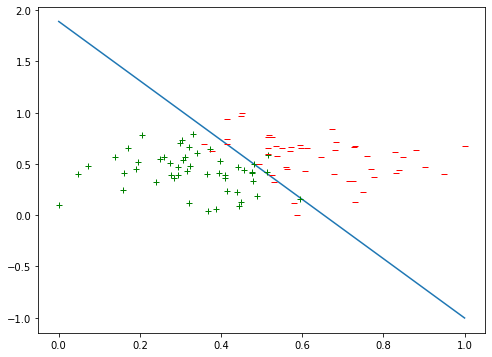

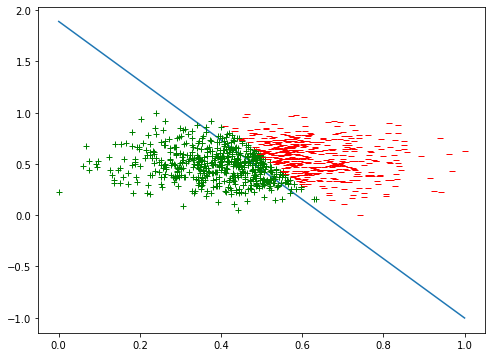

In [17]:
SVM = svm(train.transformedX, train.transformedY,0.1)
SVM.predict(test.transformedX,test.transformedY)
SVM.one_lamda_optimization(3,10000)
SVM.predict(test.transformedX,test.transformedY)
SVM.display_data(SVM.X,SVM.Y)
SVM.display_data(test.transformedX.T,test.transformedY.T)

Accuracy: 0.5380859375
[0.31293435]
[0.31293435]
[-0.66837235]
[-1.74390107]
[-1.72907431]
[-1.72907431]
[-3.95589371]
[-4.4423183]
[-3.25613477]
[-3.25613477]
Accuracy: 0.5380859375


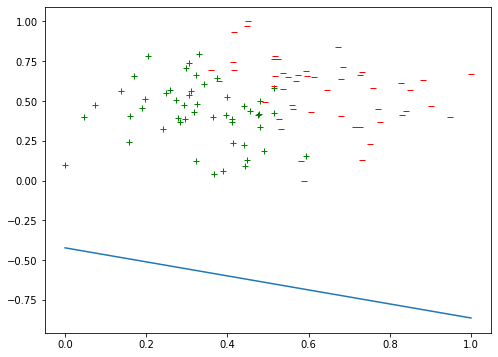

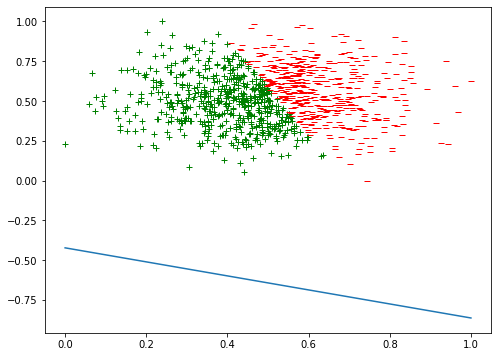

In [16]:
SVM = svm(train.transformedX, train.transformedY,0.1)
SVM.predict(test.transformedX,test.transformedY)
SVM.optimize_lagrange_evolutionary(10,3)
SVM.predict(test.transformedX,test.transformedY)
SVM.display_data(SVM.X,SVM.Y)
SVM.display_data(test.transformedX.T,test.transformedY.T)